### Clustering ###

In [49]:
from matplotlib.image import imread
import pandas as pd

## Preparing the Data ##

In [51]:
from sklearn.model_selection import train_test_split
import os, cv2
import numpy as np

# dog = 0, cat = 1
def LoadAnimals(directory, clustering=0):
    x = []
    y = []

    for filename in os.listdir(directory):
        if 'dog' in filename:
            animal_class = 0
        else: # cat
            animal_class = 1

        f = os.path.join(directory, filename)
        image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)

        if clustering != 0:
            reshaped_image = image.reshape(-1, 3)
            kmeans = KMeans(n_clusters=clustering).fit(reshaped_image)
            segmented_img = kmeans.cluster_centers_[kmeans.labels_]
            segmented_img = segmented_img.reshape(image.shape)
            image = segmented_img

        x.append(np.concatenate(image)) # sklearn doesn't like 3d arrays (x_train is an array of 2d arrays -> 3d array). Transforms 3d array to 2d.
        y.append(animal_class)

    return x, y

In [52]:
x, y = LoadAnimals(r"C:\Users\Daniel\Pictures\resize100,100", clustering=0)


In [53]:
def ImageArrayToPixelArray(arr):
    ret = []
    pixel_num = len(arr[0])

    for i in range(0, pixel_num):
        pixel_list = []
        for image in arr:
            pixel_list.append(image[i])
        ret.append(pixel_list)

    return ret
pixel_list = ImageArrayToPixelArray(x)

KeyboardInterrupt: 

In [54]:
x2 = x.copy()
array1 = np.array(x2)
df = pd.DataFrame(array1)

df


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,168,173,177,180,185,188,190,193,197,198,...,3,3,3,2,2,2,2,2,2,2
1,43,43,44,43,52,32,52,37,40,61,...,47,50,48,50,55,61,63,89,18,35
2,39,25,42,52,45,55,61,55,54,58,...,157,157,149,134,129,149,159,168,171,153
3,220,224,223,227,229,223,226,235,229,226,...,229,213,206,204,202,214,222,215,212,213
4,117,117,122,92,78,97,134,130,150,180,...,95,95,95,91,101,121,96,90,93,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,140,142,143,145,146,147,148,149,148,149,...,164,165,166,166,167,168,168,168,168,169
24996,119,77,103,84,99,114,71,82,85,87,...,95,94,80,98,86,77,85,94,92,76
24997,42,35,47,56,66,48,48,57,59,39,...,102,135,135,123,71,116,180,127,114,167
24998,253,250,246,234,223,208,187,145,114,73,...,120,101,106,112,112,112,106,118,115,119


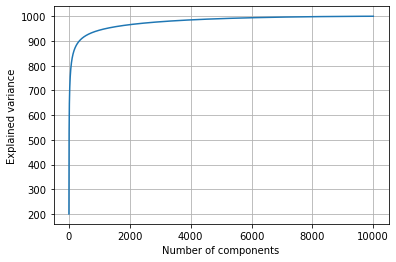

In [55]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_10000 = PCA(n_components=10000)
pca_10000.fit(df)

plt.grid()
plt.plot(np.cumsum(pca_10000.explained_variance_ratio_ * 1000))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.savefig('Scree plot.png')

Lets test n_components = 1000

In [59]:
pca_1000 = PCA(n_components=1000)
pca_1000.fit(df)

PCA(n_components=1000)

In [60]:
np.cumsum(pca_1000.explained_variance_ratio_ * 100)[-1]


94.30935189489206

In [61]:
transformed_x = pca_1000.fit_transform(x)

## Analyzing Feature Importance ##
Using Random Forest.

In [62]:
def array1dto2d(arr, w, h):
    if w*h != len(arr):
        return None
    else:
        ret = []
        for i in range(0, h):
            ret.append( arr[w*i:w*(i+1)] )
        return ret

Conclusion: It seems our pictures don't have a pattern and a specific area in which the important (or non-important, a dead space such the top right corner commonly being a wall) information is.

# Models #

In [63]:
from sklearn.model_selection import cross_val_score

def Test(name, model,x1=transformed_x,y1=y):
    score = abs(np.median( cross_val_score(model, x1, y1, cv=10, scoring='accuracy') ))
    print('{}: {}'.format(name, score))

First we will run a dummy to set our baseline.

In [64]:
from sklearn.dummy import DummyClassifier
Test('Dummy (stratified)', DummyClassifier(strategy="stratified"))
Test('Dummy (most_frequent)', DummyClassifier(strategy="most_frequent"))

Dummy (stratified): 0.5064
Dummy (most_frequent): 0.5


Next we will try out Logistic Regression (without high hopes).

In [65]:
from sklearn.ensemble import RandomForestClassifier

Test('Random Forest', RandomForestClassifier())

Random Forest: 0.5876


In [66]:
from sklearn.ensemble import BaggingClassifier
Test('Bagging Classifier', BaggingClassifier(RandomForestClassifier(), n_estimators=10, max_samples=2000))

Bagging Classifier: 0.5880000000000001


Lets try some new models: AdaBoost, XGBoost.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
Test('Random Forest', RandomForestClassifier(),x1=X_train)

Random Forest: 0.5714319215796633


Now lets run our models together using Bagging.